In [85]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [86]:
df = pd.read_csv("../Data/Hourly consumtpion per cluster London.csv")
df["time"] = df["time"].astype(str).str.zfill(3)
df.index = df["time"]
df["day"] = df["time"].str[:1]
df["hour"] = df["time"].str[1:]
df.drop(['time','Unnamed: 0'], axis = 1, inplace = True)




,consumption_kWh,Morn-Ev,CO2_intensity
time,,,
000,587.238769,Morning,206.339623
001,487.561051,Morning,214.980769
002,413.403647,Morning,214.673077
003,378.318955,Morning,215.509615
004,367.642231,Morning,216.461538


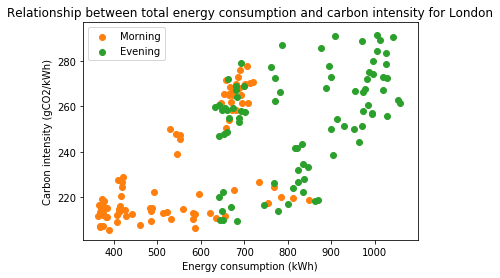

In [6]:
a = df.groupby('time')['consumption_kWh'].apply(lambda x: np.sum(x)).to_frame()

a['Morn-Ev'] = 'Morning'
a['Morn-Ev'] = a['Morn-Ev'].where(a.index.str[1:].astype(int) <12 , "Evening")
a.head()

z = df.iloc[range(0,168),-3]
a["CO2_intensity"] = z

morn = a[a['Morn-Ev']=='Morning']
ev = a[a['Morn-Ev']=='Evening']


plt.scatter(x = morn['consumption_kWh'], y = morn['CO2_intensity'], color = 'C1', label = 'Morning')
plt.scatter(x = ev['consumption_kWh'], y = ev['CO2_intensity'], color = 'C2', label = 'Evening')

plt.title("Relationship between total energy consumption and carbon intensity for London")
plt.xlabel("Energy consumption (kWh)")
plt.ylabel("Carbon intensity (gCO2/kWh)")

plt.legend()            
plt.savefig("Carbon Intensity vs Consumption London.png")

morn.head()

### Load the best model for consumption-carbon intensity mathing 

CF London Consumption-Carbon intensity model notebook for model comparison

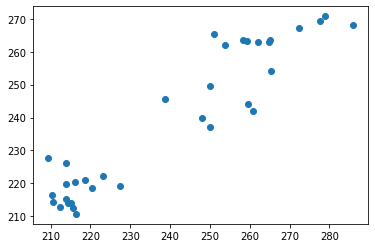

In [155]:
week = df.groupby('time')['consumption_kWh'].apply(lambda x: np.sum(x)).to_frame()
week["day"] = week.index.str[:1]
week["hour"] = week.index.str[1:]

z = df.iloc[range(0,168),-3]
week["CO2_intensity"] = z

train_data, test_data = train_test_split(week, train_size = 0.8, random_state = 3)
rf = RandomForestRegressor(max_depth=5, random_state=0)

X_train = np.array(train_data[['consumption_kWh','day','hour']],
                   dtype = pd.Series)
y_train = np.array(train_data['CO2_intensity'], dtype = pd.Series)

X_test = np.array(test_data[['consumption_kWh','day','hour']], 
                    dtype = pd.Series)
y_test = np.array(test_data['CO2_intensity'], dtype = pd.Series)


rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
plt.scatter(y_test,y_pred)

In [5]:
a['consumption_kWh'].corr(a['CO2_intensity'])

0.6462240151104416

## Reduction of energy consumption 

### Peak consumption reduction in cluster 5 

Evaluate the impact a X% reduction in energy consumption of a cluster during evening peak could have on overall consumption and co2 emissions. 

We look at cluster 5 between 6 and 10 pm

In [12]:
eff = df.copy()

eff["Efficiency"] = 1
eff.head()

eff["Efficiency"] = eff["Efficiency"].where(
    ((eff["hour"] != "06") & (eff["hour"] != "07") & (eff["hour"] != "08")
    & (eff["hour"] != "09") &(eff["hour"] != "10")) | (eff["Cluster"] != 4 ) , 0.98)


In [23]:
eff["consumption_kWh"] = eff["consumption_kWh"]*eff["Efficiency"]

eff["CO2_intensity"] = rf.predict(np.array(eff[['consumption_kWh','day','hour']], 
                    dtype = pd.Series))



#cluster_emissions = eff.groupby('Cluster')["Emissions"].apply(lambda x: np.sum(x
                                                     #               )).to_frame()

eff.head()

,Cluster,consumption_kWh,CO2_intensity,day,hour,Efficiency
time,,,,,,
000,0,33.813385,211.076851,0,00,1.0
001,0,37.310308,211.317785,0,01,1.0
002,0,29.514769,211.467915,0,02,1.0
003,0,31.131462,211.366089,0,03,1.0
004,0,39.650769,211.484935,0,04,1.0


<BarContainer object of 5 artists>

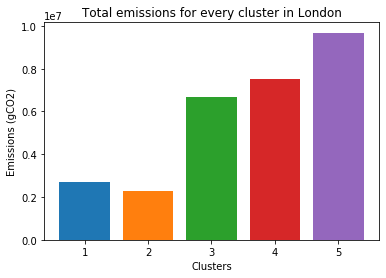

In [8]:
plt.title("Total emissions for every cluster in London")
plt.xlabel("Clusters")
plt.ylabel('Emissions (gCO2)')
plt.bar(cluster_emissions.index+1, cluster_emissions['Emissions'], color =["C0", "C1", "C2", "C3", "C4"])

In [9]:
total_emissions = cluster_emissions['Emissions'].sum()
total_emissions

28858493.4298305

1eee
344.9943846153846
73449.23813954147eee
73449.23813954147
69776.77623256439eee
69776.77623256439
66104.31432558731eee
66104.31432558731
62431.85241861024eee
62431.85241861024
58759.39051163316eee
58759.39051163316
55086.92860465608eee
55086.92860465608
51414.46669767901eee
51414.46669767901
47742.00479070193eee
47742.00479070193
44069.542883724855eee
44069.542883724855
40397.08097674778eee
40397.08097674778


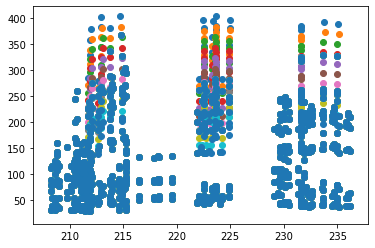

In [70]:
eff = df.copy()

decrease = np.arange(1, 0.45, -0.05)
result = [None]*len(decrease)
#print(len(decrease))
eff["Efficiency"] = 1

for i in range(len(decrease)) : 
    
    eff["Efficiency"] = eff["Efficiency"].where(
        ((eff["hour"] != "18") & (eff["hour"] != "19") & (eff["hour"] != "20")
        & (eff["hour"] != "21") &(eff["hour"] != "22")) | (eff["Cluster"] != 4 ) , decrease[i])
    print(str(eff.iloc[-3,-1]) + 'eee')
    eff["consumption_kWh1"] = eff["consumption_kWh"]*eff["Efficiency"]
    print(eff.iloc[-3,-1])
    eff["CO2_intensity"] = rf.predict(np.array(eff[['consumption_kWh1','day','hour']], 
                    dtype = pd.Series))
    plt.scatter(eff['CO2_intensity'],eff["consumption_kWh1"])
    eff["Emissions"] = eff["consumption_kWh1"]*eff["CO2_intensity"]
    
    result[i] = eff["Emissions"].sum()

plt.xlim(1, 0.5)
plt.ylabel("CO2 Emissions (gCO2)")
plt.xlabel("Efficiency improvement (%)")
plt.title("Emission reduction for different efficiency improvements of the peak load in cluster 5")
my_xticks = [0,5,10,15,20,25,30,35,40,45,50]
plt.xticks(decrease,my_xticks)
plt.plot(decrease,result)
eff

In [56]:
eff = df.copy()
eff.tail()

,Cluster,consumption_kWh,CO2_intensity,day,hour
time,,,,,
619,4,402.529833,261.442308,6,19
620,4,383.303192,255.855769,6,20
621,4,344.994385,244.259615,6,21
622,4,279.189365,226.846154,6,22
623,4,197.887051,210.009615,6,23


Emissions reductions is the most optimal for efficiency improvements of 10 to 30%. Afterwards, the effect is significantly reduced. 

### Overall Cluster 5 Improvement 

11


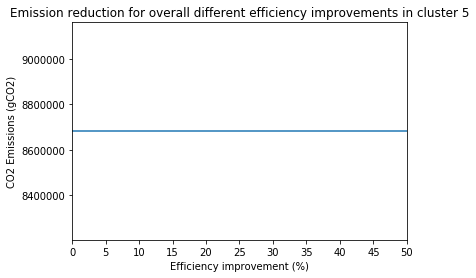

In [50]:
c5_eff = df.copy()

decrease = np.arange(1, 0.45, -0.05)
result = [None]*len(decrease)
print(len(decrease))

c5_eff["efficiency"] = 1
for i in range(len(decrease)) : 
    
    c5_eff["efficiency"] = c5_eff["efficiency"].where(
        eff["Cluster"] != 4 , decrease[i])
    c5_eff["consumption_kWh1"] = c5_eff["consumption_kWh"]*c5_eff["efficiency"]

    c5_eff["CO2_intensity"] = rf.predict(np.array(c5_eff[['consumption_kWh','day','hour']], 
                    dtype = pd.Series))

    c5_eff["Emissions"] = c5_eff["consumption_kWh"]*eff["CO2_intensity"]
    cluster_emissions = c5_eff.groupby('Cluster')["Emissions"].apply(lambda x: np.sum(x
                                                                      )).to_frame()
    result[i] = cluster_emissions.iloc[4,0]

plt.xlim(1, 0.5)
plt.ylabel("CO2 Emissions (gCO2)")
plt.xlabel("Efficiency improvement (%)")
plt.title("Emission reduction for overall different efficiency improvements in cluster 5")
my_xticks = [0,5,10,15,20,25,30,35,40,45,50]
plt.xticks(decrease,my_xticks)
plt.plot(decrease,result)

In [42]:
c5_eff = df.copy()
c5_eff["efficiency"] = 1
c5_eff["efficiency"] = c5_eff["efficiency"].where(
        eff["Cluster"] != 4 , 4)

c5_eff.tail()


,Cluster,consumption_kWh,CO2_intensity,day,hour,efficiency
time,,,,,,
619,4,402.529833,261.442308,6,19,4
620,4,383.303192,255.855769,6,20,4
621,4,344.994385,244.259615,6,21,4
622,4,279.189365,226.846154,6,22,4
623,4,197.887051,210.009615,6,23,4


### Overall efficiency improvement 

11
26002977.591305
24703152.27019855
23402991.167800922
22102824.99181198
20802658.81582304
19502492.639834095
18202326.463845156
16902160.287856214
15601994.111867271
14301827.93587833
13001661.75988939


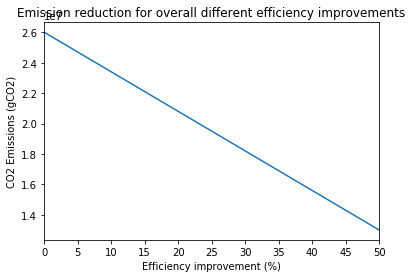

In [158]:
ov_eff = df.copy()

decrease = np.arange(1, 0.45, -0.05)
result = [None]*len(decrease)
print(len(decrease))

columns = decrease

df1 = pd.DataFrame(columns = columns)

ov_eff["efficiency"] = 1
for i in range(len(decrease)) : 
    
    ov_eff["efficiency"] = decrease[i]
    ov_eff["consumption_kWh1"] = ov_eff["consumption_kWh"]*ov_eff["efficiency"]
    #print(ov_eff["consumption_kWh1"])
   
    #ov_eff.iloc[]
    ov_eff["CO2_intensity"] = rf.predict(np.array(ov_eff[['consumption_kWh1','day','hour']], 
                    dtype = pd.Series))
    #ov_eff["CO2_intensity"]
    ov_eff["Emissions"] = ov_eff["consumption_kWh1"]*ov_eff["CO2_intensity"]
    
    result1[i] = ov_eff["Emissions"].sum()
    print(ov_eff["Emissions"].sum())

plt.xlim(1, 0.5)
plt.ylabel("CO2 Emissions (gCO2)")
plt.xlabel("Efficiency improvement (%)")
plt.title("Emission reduction for overall different efficiency improvements")
my_xticks = [0,5,10,15,20,25,30,35,40,45,50]
plt.xticks(decrease,my_xticks)
plt.plot(decrease,result1)
#ov_eff['CO2_intensity']

11


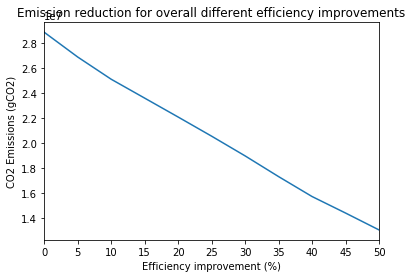

In [159]:
ov_eff = df.copy()

decrease = np.arange(1, 0.45, -0.05)
result = [None]*len(decrease)
print(len(decrease))

columns = decrease

df1 = pd.DataFrame(columns = columns)

ov_eff["efficiency"] = 1
for i in range(len(decrease)) : 
    
    ov_eff["efficiency"] = decrease[i]
    ov_eff["consumption_kWh1"] = ov_eff["consumption_kWh"]*ov_eff["efficiency"]
    #print(ov_eff["consumption_kWh1"])
    a = ov_eff.groupby(ov_eff.index)["consumption_kWh1"].apply(lambda x: np.sum(x)).to_frame()
    a["day"] = a.index.str[:1]
    a["hour"] = a.index.str[1:]
    
    a['CO2_intensity'] = rf.predict(np.array(a[['consumption_kWh1','day','hour']], 
                    dtype = pd.Series))

    #print(a)
    #ov_eff.iloc[]
    ov_eff["CO2_intensity"] = rf.predict(np.array(ov_eff[['consumption_kWh1','day','hour']], 
                    dtype = pd.Series))
    #ov_eff["CO2_intensity"]
    a["Emissions"] = a["consumption_kWh1"]*a["CO2_intensity"]
    
    result[i] = a["Emissions"].sum()
    #print(ov_eff["Emissions"].sum())

plt.xlim(1, 0.5)
plt.ylabel("CO2 Emissions (gCO2)")
plt.xlabel("Efficiency improvement (%)")
plt.title("Emission reduction for overall different efficiency improvements")
my_xticks = [0,5,10,15,20,25,30,35,40,45,50]
plt.xticks(decrease,my_xticks)
plt.plot(decrease,result)
#ov_eff['CO2_intensity']


In [148]:
a.head()

,consumption_kWh1
time,
000,293.619385
001,243.780526
002,206.701824
003,189.159478
004,183.821115


In [110]:
rf.predict(np.array(ov_eff[['consumption_kWh1','day','hour']].iloc[[1],[0,1,2]]))



array([211.31778483])

In [135]:
np.array(ov_eff[['consumption_kWh1','day','hour']].iloc[[1,2,3],[0,1,2]])


rf.predict(np.array([[200,'','01']]))

array([211.01865507])